## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload() 

Saving complaints.json to complaints (1).json


## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [20]:
# Opening JSON file 
f = open("complaints.json",'r')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [9]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [12]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [21]:
#Assign new column names
df.rename(columns = {'_index':'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
       '_source.complaint_what_happened':'complaint', '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [23]:
#Assign nan in place of blanks in the complaints column
df.complaint.replace('',np.NaN,inplace=True)

In [30]:
#Remove all rows where complaints column is nan
print('Nan before' , df.complaint.isna().count())
df = df[~df.complaint.isnull()]
print('Nan after' , df.complaint.isna().count())

Nan before 78313
Nan after 21072


In [74]:
#select small sample size 
df = df.head(400)
df.shape

(400, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [62]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(doc):
    doc = doc.lower()
    doc= re.sub('[^a-zA-Z]',' ',doc)
    '''regex_square = r'\[.+?\]'
    regex_punc = r'[\W\S]*'
    regex_num =r'[\w]*\d[\w]*'
    doc = re.sub(regex_square,'',doc)
    doc = re.sub(regex_punc,'',doc)
    doc = re.sub(regex_num,'',doc)'''
    return doc
    

In [59]:
#Before cleaning text
df.complaint.head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint, dtype: object

In [63]:
# Test Reg expressions on a sample text
#After cleaning text
df.complaint.apply(lambda x:clean_text(x)).head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in xx xx      and...
10    chase card was reported on xx xx       however...
11    on xx xx       while trying to book a xxxx  xx...
14    my grand son give me check for            i de...
Name: complaint, dtype: object

In [64]:
df['complaint'] = df.complaint.apply(lambda x:clean_text(x))

In [67]:
#Importing necessary libraries for lemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
Lemma = WordNetLemmatizer()



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OMEGA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [72]:
#Write your function to Lemmatize the texts
def lemmatize(text):
    tokens = word_tokenize(text)
    words = [Lemma.lemmatize(token) for token in tokens if not token in set(stopwords.words('english'))]
    return " ".join(words)

In [75]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaint'] = df.complaint
df_clean['lemmatized_complaints'] = df.complaint.apply(lambda x:lemmatize(x))
df_clean.head()

,complaint,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in xx xx and...,upgraded xxxx xxxx card xx xx told agent upgra...
10,chase card was reported on xx xx however...,chase card reported xx xx however fraudulent a...
11,on xx xx while trying to book a xxxx xx...,xx xx trying book xxxx xxxx ticket came across...
14,my grand son give me check for i de...,grand son give check deposit chase account fun...


In [ ]:
df_clean

In [98]:
#Write your function to extract the POS tags 
def pos_extract(text):
    pos_tags =[]
    doc = nlp(text)
    for tok in doc:
        if tok.pos_ in ['NOUN','ADJ','AUX','PROPN']:
            pos_tags.append(tok.text)
    return ' '.join(pos_tags)
    


In [99]:
df_clean['pos_tags'] = df['lemmatized_complaints'].apply(lambda x:pos_extract(x))
df_clean

,complaint,lemmatized_complaints,pos_tags
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,good morning name is xxxx xxxx could stop bank...
2,i upgraded my xxxx xxxx card in xx xx and...,upgraded xxxx xxxx card xx xx told agent upgra...,xxxx xxxx card xx xx was agent anniversary dat...
10,chase card was reported on xx xx however...,chase card reported xx xx however fraudulent a...,chase card was xx xx fraudulent application ha...
11,on xx xx while trying to book a xxxx xx...,xx xx trying book xxxx xxxx ticket came across...,xx xx xxxx xxxx ticket offer be ticket rewards...
14,my grand son give me check for i de...,grand son give check deposit chase account fun...,grand son check chase account fund clear chase...
...,...,...,...
984,chase card address xxxx xxxx xxxx city stat...,chase card address xxxx xxxx xxxx city state z...,chase card address xxxx xxxx xxxx city state x...
990,hi for the past months i ve been going back...,hi past month going back forth credit reportin...,past months ve been credit reporting agencies ...
991,on xx xx i have scheduled one transfer to...,xx xx scheduled one transfer account xxxx xxxx...,xx xx have transfer account xxxx xxxx xxxx was...
992,hello i was called by a chase bank representa...,hello called chase bank representative xx xx x...,was chase bank representative xx xx xxxx repre...


In [117]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] = [' '.join(set(a.split()) - set(b.split())) for a,b in zip(df_clean['lemmatized_complaints'] , df_clean['pos_tags'])]
df_clean.drop(labels='pos_tags',axis=1,inplace=True)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




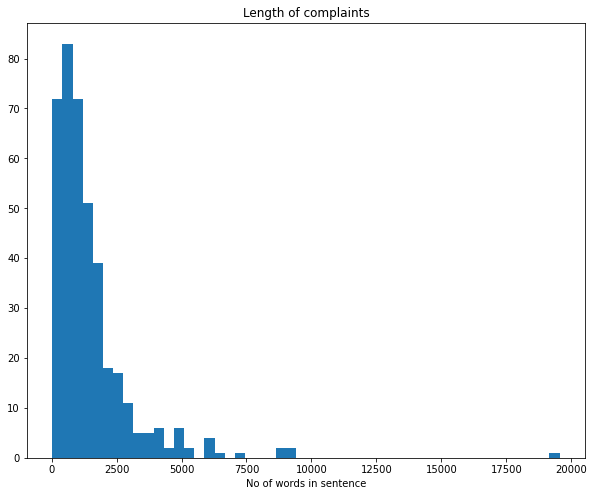

In [116]:
# Write your code here to visualise the data according to the 'Complaint' character length
compalaint_len = [len(i) for i in df_clean['complaint_POS_removed']]
plt.figure(figsize=(10,8))
plt.hist(compalaint_len,bins=50)
plt.xlabel('No of words in sentence')
plt.title('Length of complaints')
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

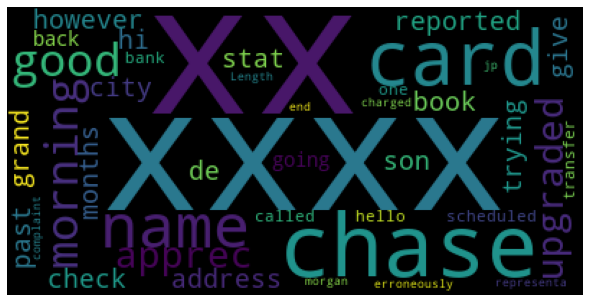

In [122]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
#Word Cloud is a data visualization technique used for representing text data in which the size of each word
#indicates its frequency or importance

from wordcloud import WordCloud

stoplist = set(stopwords.words('english'))

wordcloud = WordCloud(stopwords = stoplist,max_words = 40 ).generate(str(df_clean['complaint_POS_removed']))


plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [123]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [171]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_unigrams(corpus,n=None):
    vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
    return words_freq[:n]

def plot_ngrams(top10):
    x = pd.DataFrame(top10,columns=['ngram','count'])
    plt.figure(figsize=(15,10))
    sns.barplot(x=x['ngram'],y=x['count'])

get_top_n_unigrams(df_clean.Complaint_clean,n=30)                   

[('told', 146),
 ('called', 137),
 ('received', 131),
 ('said', 102),
 ('sent', 94),
 ('paid', 78),
 ('contacted', 76),
 ('asked', 74),
 ('went', 71),
 ('closed', 67),
 ('going', 66),
 ('used', 65),
 ('make', 64),
 ('pay', 63),
 ('just', 62),
 ('like', 60),
 ('later', 58),
 ('know', 56),
 ('receive', 56),
 ('need', 54),
 ('tried', 54),
 ('charged', 54),
 ('provided', 53),
 ('opened', 52),
 ('spoke', 51),
 ('stated', 51),
 ('using', 50),
 ('filed', 48),
 ('reported', 47),
 ('informed', 47)]

In [172]:
#Print the top 10 words in the unigram frequency
top_10_unigram = get_top_n_unigrams(df_clean.Complaint_clean, n=10)
for i in top_10_unigram:
    print(i[0])

told
called
received
said
sent
paid
contacted
asked
went
closed


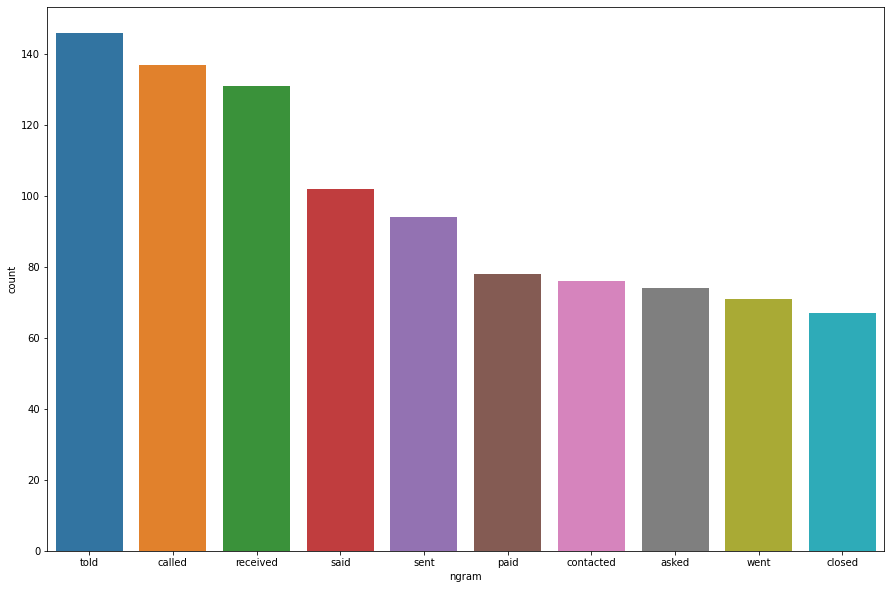

In [173]:
plot_ngrams(top_10_unigram)

In [174]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    #print('--1',sum_of_words)
    #for word,idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        #break
    words_freq =[(word , sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items() ]
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse = True)
    return words_freq[:n]

get_top_n_bigrams(df_clean.Complaint_clean, n=30)

[('pay called', 20),
 ('called charged', 19),
 ('using going', 14),
 ('told close', 13),
 ('provide called', 13),
 ('told received', 13),
 ('told tell', 13),
 ('used closed', 12),
 ('stated paid', 12),
 ('longer said', 12),
 ('called saw', 12),
 ('called need', 11),
 ('pay provide', 11),
 ('applied called', 10),
 ('said needed', 10),
 ('said reported', 9),
 ('just contacted', 9),
 ('going signed', 9),
 ('transferred tried', 8),
 ('went given', 8),
 ('contact going', 8),
 ('sent send', 8),
 ('instead spoke', 8),
 ('charged need', 8),
 ('received change', 8),
 ('said pay', 7),
 ('look told', 7),
 ('set asked', 7),
 ('followed told', 7),
 ('receive spent', 7)]

In [175]:
#Print the top 10 words in the bigram frequency
top_10_bigram = get_top_n_bigrams(df_clean.Complaint_clean, n=10)
for i in top_10_bigram:
    print(i[0])

pay called
called charged
using going
told close
provide called
told received
told tell
used closed
stated paid
longer said


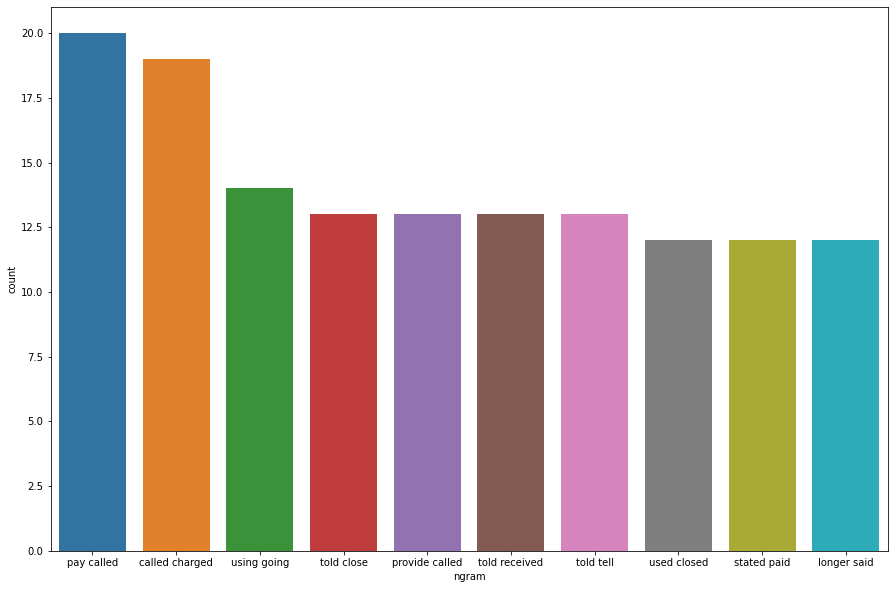

In [176]:
plot_ngrams(top_10_bigram)

In [177]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    #print('--1',sum_of_words)
    #for word,idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        #break
    words_freq =[(word , sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items() ]
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse = True)
    return words_freq[:n]

get_top_n_trigrams(df_clean.Complaint_clean, n=30)

[('called charged need', 5),
 ('pay called charged', 5),
 ('told tell close', 4),
 ('provide called charged', 4),
 ('using going signed', 4),
 ('using look told', 3),
 ('confirmed informed attached', 3),
 ('said pay provide', 3),
 ('pay provide called', 3),
 ('provide called saw', 3),
 ('receiving used closed', 3),
 ('longer said reported', 3),
 ('having provided gave', 3),
 ('given open sent', 3),
 ('receive spent allow', 3),
 ('taken open sent', 3),
 ('called saw need', 3),
 ('refuse called need', 2),
 ('said pay called', 2),
 ('like post called', 2),
 ('remove additionally got', 2),
 ('provided gave trying', 2),
 ('stated paid cancelled', 2),
 ('supposed waiting asked', 2),
 ('contact using going', 2),
 ('using going heard', 2),
 ('going heard speaking', 2),
 ('heard speaking decided', 2),
 ('named like apply', 2),
 ('explained specifically receive', 2)]

In [178]:
#Print the top 10 words in the trigram frequency
top_10_trigram = get_top_n_trigrams(df_clean.Complaint_clean, n=10)
for i in top_10_trigram:
    print(i[0])

called charged need
pay called charged
told tell close
provide called charged
using going signed
using look told
confirmed informed attached
said pay provide
pay provide called
provide called saw


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

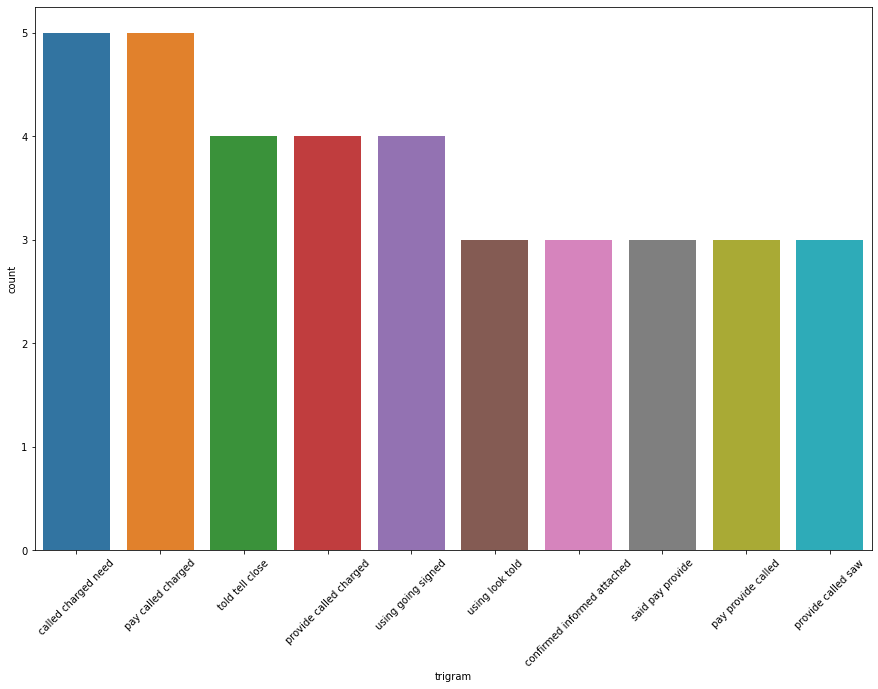

In [186]:
#plot_ngrams(top_10_trigram)
x = pd.DataFrame(top_10_trigram,columns=['trigram','count'])
plt.figure(figsize=(15,10))
sns.barplot(x=x['trigram'],y=x['count'])
plt.xticks(rotation=45)


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [147]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean']df_clean['Complaint_clean'].str.replace('xxxx','')

In [148]:
#All masked texts has been removed
df_clean

,complaint,lemmatized_complaints,removed_pos_tags,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,they and from put i wrote know this a not ever...,they and from put i wrote know this a not ever...,they and from put i wrote know this a not ever...
2,i upgraded my xxxx xxxx card in xx xx and...,upgraded xxxx xxxx card xx xx told agent upgra...,without upgrade and from i not turned it my in...,without upgrade and from i not turned it my in...,without upgrade and from i not turned it my in...
10,chase card was reported on xx xx however...,chase card reported xx xx however fraudulent a...,without my not fraudulently to however the ver...,without my not fraudulently to however the ver...,without my not fraudulently to however the ver...
11,on xx xx while trying to book a xxxx xx...,xx xx trying book xxxx xxxx ticket came across...,contacted go they and within not then proceed ...,contacted go they and within not then proceed ...,contacted go they and within not then proceed ...
14,my grand son give me check for i de...,grand son give check deposit chase account fun...,happen they speek said i call he not pay for r...,happen they speek said i call he not pay for r...,happen they speek said i call he not pay for r...
...,...,...,...,...,...
984,chase card address xxxx xxxx xxxx city stat...,chase card address xxxx xxxx xxxx city state z...,b making another required and constitute withi...,b making another required and constitute withi...,b making another required and constitute withi...
990,hi for the past months i ve been going back...,hi past month going back forth credit reportin...,make that hi soon they deleted and i towards k...,make that hi soon they deleted and i towards k...,make that hi soon they deleted and i towards k...
991,on xx xx i have scheduled one transfer to...,xx xx scheduled one transfer account xxxx xxxx...,si that up below transpired and call including...,si that up below transpired and call including...,si that up below transpired and call including...
992,hello i was called by a chase bank representa...,hello called chase bank representative xx xx x...,they another and issue finally within not comp...,they another and issue finally within not comp...,they another and issue finally within not comp...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [188]:
#Write your code here to initialise the TfidfVectorizer 
tf_idf = TfidfVectorizer(max_df= 90 , min_df=10)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_vectors = tf_idf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [189]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [196]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = num_topics,random_state = 40)

W1 = nmf_model.fit_transform(tfidf_vectors)
H1 = nmf_model.components_

C:\Users\OMEGA\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

C:\Users\OMEGA\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [197]:
H1

array([[0.        , 0.05493665, 0.        , ..., 0.08005633, 0.10891437,
        0.00470595],
       [0.080291  , 0.03534946, 0.05480366, ..., 0.02710655, 0.04354344,
        0.25768349],
       [0.02227252, 0.02936784, 0.06687622, ..., 0.        , 0.        ,
        0.01253874],
       [0.00905199, 0.        , 0.        , ..., 0.00142018, 0.07660753,
        0.        ],
       [0.        , 0.        , 0.00613017, ..., 0.        , 0.05152046,
        0.07747683]])

In [195]:
nmf_model.fit(tfidf_vectors)
len(tf_idf.get_feature_names())

C:\Users\OMEGA\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

C:\Users\OMEGA\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

C:\Users\OMEGA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



390

In [199]:
#Print the Top15 words for each of the topics
num_words = 15

vocab = np.array(tf_idf.get_feature_names())

top_words = lambda t:[vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



